# Table of Contents
 <p><div class="lev1"><a href="#Initialize-Environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev1"><a href="#Subgraph-of-Brain-Systems-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Subgraph of Brain Systems</a></div><div class="lev2"><a href="#Focal-vs-Distributed-Subgraphs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Focal vs Distributed Subgraphs</a></div><div class="lev2"><a href="#Formulate-ROI-Dict-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Formulate ROI Dict</a></div><div class="lev2"><a href="#Convert-ROI-Subgraphs-to-Brain-System-Subgraphs-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Convert ROI Subgraphs to Brain System Subgraphs</a></div><div class="lev2"><a href="#Within-Task-Subgraph-Contrast-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Within-Task Subgraph Contrast</a></div><div class="lev2"><a href="#Between-Task-Subgraph-Contrast-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Between-Task Subgraph Contrast</a></div><div class="lev2"><a href="#Subgraph-Expression-vs-Behavior-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Subgraph Expression vs Behavior</a></div><div class="lev3"><a href="#Load-Behavioral-Data-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Load Behavioral Data</a></div><div class="lev3"><a href="#Predicting-No-Interference/Shifting-Median-RT-2.6.2"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>Predicting No-Interference/Shifting Median RT</a></div><div class="lev3"><a href="#Predicting-Interference/Shifting-Median-RT-(from-Hi-alone)-2.6.3"><span class="toc-item-num">2.6.3&nbsp;&nbsp;</span>Predicting Interference/Shifting Median RT (from Hi alone)</a></div><div class="lev3"><a href="#Predicting-Interference/Shifting-Median-RT-(from-Hi-Lo-Contrast)-2.6.4"><span class="toc-item-num">2.6.4&nbsp;&nbsp;</span>Predicting Interference/Shifting Median RT (from Hi-Lo Contrast)</a></div>

# Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
os.chdir('./Analysis_Notebooks/')

path_Remotes = '/Users/akhambhati/Remotes'
path_CoreData = path_Remotes + '/CORE.fMRI_cogcontrol.medaglia'
path_RsrchData = path_Remotes + '/RSRCH.NMF_CogControl'
path_InpData = path_RsrchData + '/e02-FuncSubg'
path_ExpData = path_RsrchData + '/e04-FuncSubg_Dynamics'

for path in [path_CoreData, path_RsrchData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/Users/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Subgraph of Brain Systems

In [2]:
df_nmf = np.load('{}/NMF_Consensus.npz'.format(path_InpData), mmap_mode='r')
fac_subnet = df_nmf['fac_subnet']
fac_coef = df_nmf['fac_coef']
n_fac = fac_subnet.shape[0]
n_conn = fac_subnet.shape[1]
n_obs = fac_coef.shape[1]

## Focal vs Distributed Subgraphs

(0, 54)

/Users/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


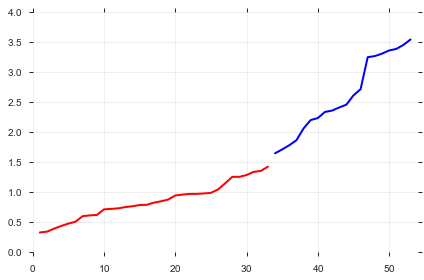

In [3]:
real_subg_skew = np.array([stats.skew(subg) for subg in fac_subnet])
real_ix = np.argsort(real_subg_skew)

n_null = 10000
rnd_coef = np.random.uniform(size=(n_null, n_fac))
rnd_subnet = np.dot(rnd_coef, fac_subnet)

rnd_subg_skew = np.array([stats.skew(subg) for subg in rnd_subnet])
rnd_ix = np.argsort(rnd_subg_skew)

low_ix = np.flatnonzero(real_subg_skew[real_ix] < np.min(rnd_subg_skew))
mid_ix = np.flatnonzero((real_subg_skew[real_ix] >= np.min(rnd_subg_skew)) &
                        (real_subg_skew[real_ix] <= np.max(rnd_subg_skew)))
high_ix = np.flatnonzero(real_subg_skew[real_ix] > np.max(rnd_subg_skew))

%matplotlib inline
plt.figure()
ax = plt.subplot(111)
ax.plot(low_ix, real_subg_skew[real_ix][low_ix], color='b')
ax.plot(mid_ix, real_subg_skew[real_ix][mid_ix], color='r')
ax.plot(high_ix, real_subg_skew[real_ix][high_ix], color='b')
ax.set_xlim([0, n_fac])

## Formulate ROI Dict

In [4]:
df_parcel = pd.read_csv('{}/LausanneScale125.csv'.format(path_CoreData))

all_roi_names = []

roi_dict = {}
for lbl_id, lbl_roi, lbl_hemi in zip(df_parcel.Label_ID, df_parcel.ROI, df_parcel.Hemisphere):
    roi_name = '{}_{}'.format(lbl_hemi, lbl_roi.split('_')[0])
    #roi_name = lbl_roi.split('_')[0]
    
    if roi_name not in all_roi_names:
        all_roi_names.append(roi_name)

    try:
        roi_dict[roi_name]
    except KeyError:
        roi_dict[roi_name] = []

    roi_dict[roi_name].append(lbl_id-1)
n_roi = len(all_roi_names)
n_conn_roi = int(n_roi*(n_roi-1)*0.5)

## Convert ROI Subgraphs to Brain System Subgraphs

In [5]:
bs_fac_subnet = np.zeros((n_fac, n_conn_roi))
for fac_i, subg in enumerate(fac_subnet):
    adj = conv_cfg_vec_to_adj_matr(subg)
    
    tmp_subnet = np.zeros((1, n_roi, n_roi))
    for ij_ii, ij_roi in enumerate(all_roi_names):
        for ik_ii, ik_roi in enumerate(all_roi_names):
            
            mean_conn = adj[roi_dict[ij_roi], :][:, roi_dict[ik_roi]].mean()
            tmp_subnet[0, ij_ii, ik_ii] = mean_conn
    bs_fac_subnet[fac_i, :] = conv_adj_matr_to_cfg_matr(tmp_subnet)[0, :]

## Within-Task Subgraph Contrast

LH_cuneus
LH_pericalcarine
RH_cuneus
LH_lingual
RH_pericalcarine
RH_lingual



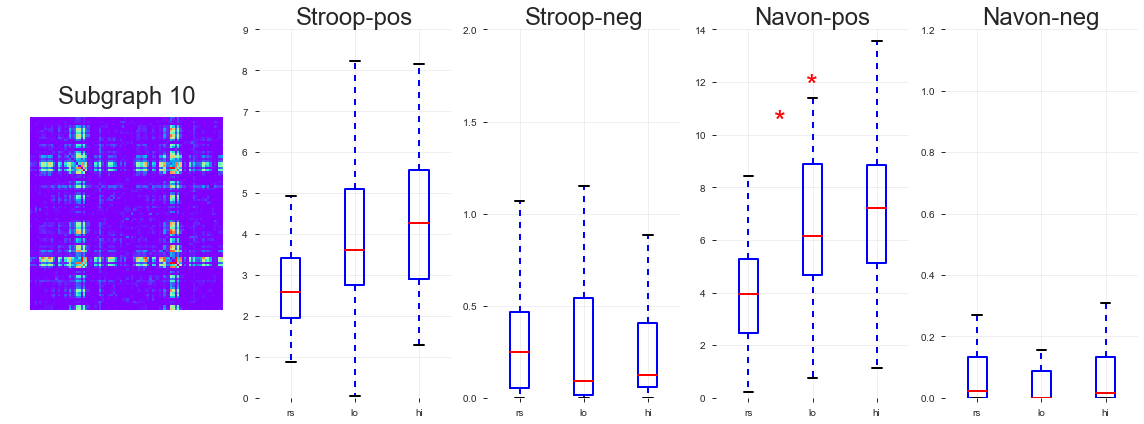

RH_caudalmiddlefrontal
RH_inferiorparietal
RH_rostralmiddlefrontal
RH_parsorbitalis
LH_lateraloccipital
RH_middletemporal



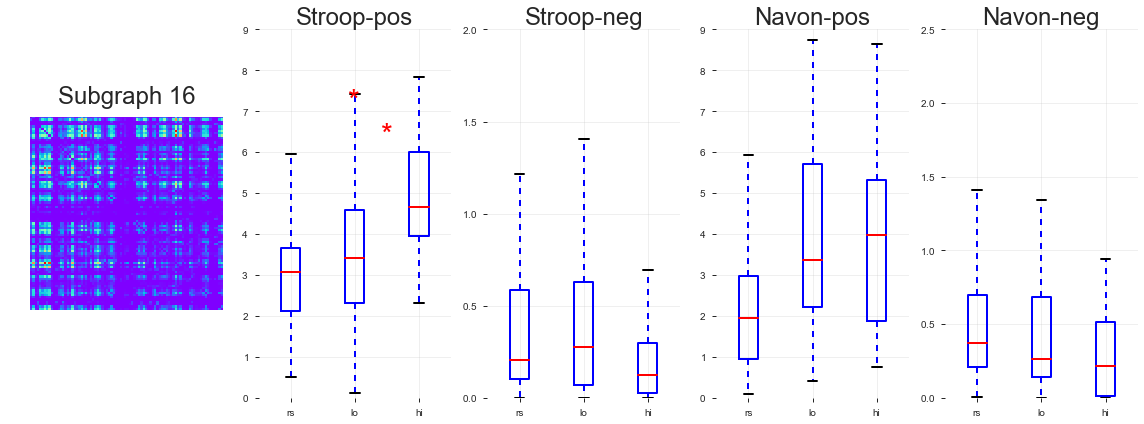

RH_postcentral
LH_medialorbitofrontal
LH_paracentral
LH_rostralanteriorcingulate
LH_postcentral
RH_paracentral



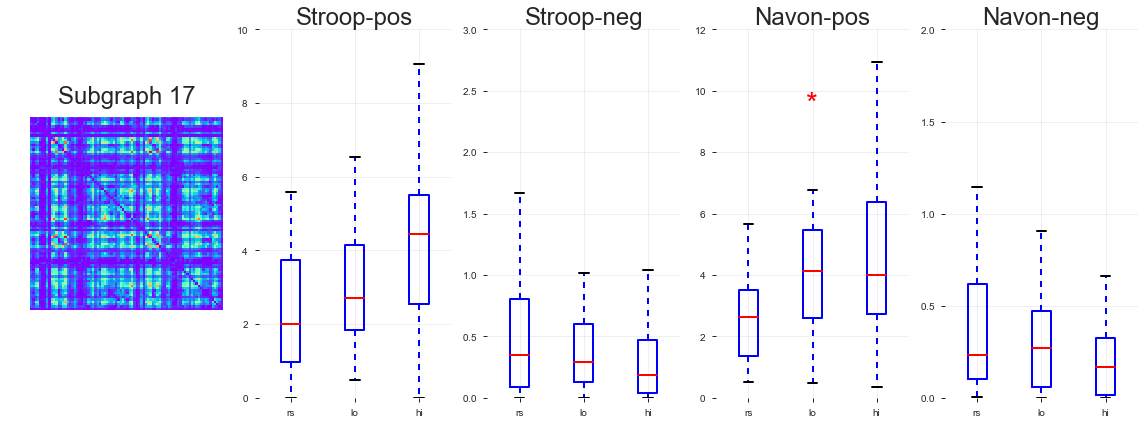

LH_lateraloccipital
LH_fusiform
RH_lateraloccipital
RH_fusiform
LH_precentral
LH_superiorparietal



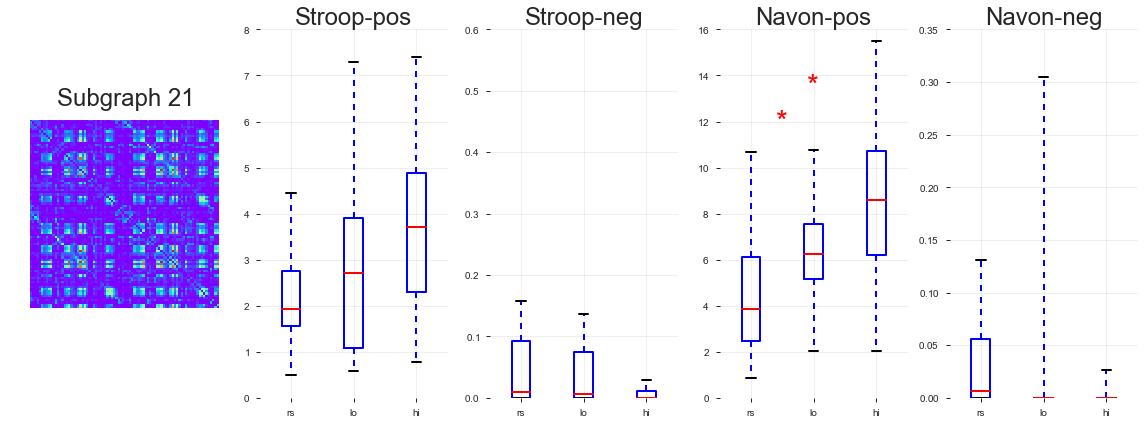

In [82]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_lbl = np.unique(cfg_key)
key_grp = [['adj_rs_pos_Stroop', 'adj_lo_pos_Stroop', 'adj_hi_pos_Stroop'],
           ['adj_rs_neg_Stroop', 'adj_lo_neg_Stroop', 'adj_hi_neg_Stroop'],
           ['adj_rs_pos_Navon', 'adj_lo_pos_Navon', 'adj_hi_pos_Navon'],
           ['adj_rs_neg_Navon', 'adj_lo_neg_Navon', 'adj_hi_neg_Navon']]


#sel_fac_ix = xrange(n_fac)
sel_fac_ix = real_ix[high_ix]
alpha = 0.05
n_comp = len(sel_fac_ix)*3*4
adj_alpha = alpha / n_comp

sel_fac_ix_within_sig = [9,15,16,20]

# Plot each result
for fac_ii in sel_fac_ix_within_sig:
    plt.figure(figsize=(16,6))
    ax = plt.subplot(1, 1+len(key_grp), 1)
    ax.matshow(conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]), cmap='rainbow')
    ax.set_axis_off()

    ax.set_title('Subgraph {}'.format(fac_ii+1))
    sort_roi = np.argsort(np.sum(conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]), axis=0))[::-1]
    print('{}\n{}\n{}\n{}\n{}\n{}\n'.format(all_roi_names[sort_roi[0]],
                                            all_roi_names[sort_roi[1]],
                                            all_roi_names[sort_roi[2]],
                                            all_roi_names[sort_roi[3]],
                                            all_roi_names[sort_roi[4]],
                                            all_roi_names[sort_roi[5]]))

    for grp_ii, grp in enumerate(key_grp):
        dists = []

        for key in grp:
            key_ix = np.flatnonzero(cfg_key == key)

            mean_subj_coef = np.mean(fac_coef[fac_ii, key_ix].reshape(-1, 6), axis=1)
            dists.append(mean_subj_coef)
            #all_coef = fac_coef[fac_ii, key_ix]
            #dists.append(all_coef)

        ax = plt.subplot(1, 1+len(key_grp), grp_ii+2)
        ax.boxplot(dists)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticklabels([gg.split('_')[1] for gg in grp])

        ax.set_title('{}-{}'.format(grp[0].split('_')[-1],
                                    grp[0].split('_')[-2]))
        
        rs_lo_ts, rs_lo_pv = stats.ttest_rel(dists[0], dists[1])
        rs_hi_ts, rs_hi_pv = stats.ttest_rel(dists[0], dists[2])
        lo_hi_ts, lo_hi_pv = stats.ttest_rel(dists[1], dists[2])            
     
        
        if rs_lo_pv < adj_alpha:
            ax.text(1.4, np.max(dists)*0.75, '*', fontsize=30, color='r')
        if lo_hi_pv < adj_alpha:
            ax.text(2.4, np.max(dists)*0.75, '*', fontsize=30, color='r')
        if rs_hi_pv < adj_alpha:
            ax.text(1.9, np.max(dists)*0.85, '*', fontsize=30, color='r')
    plt.show()

## Between-Task Subgraph Contrast

LH_cuneus
LH_pericalcarine
RH_cuneus
LH_lingual
RH_pericalcarine
RH_lingual



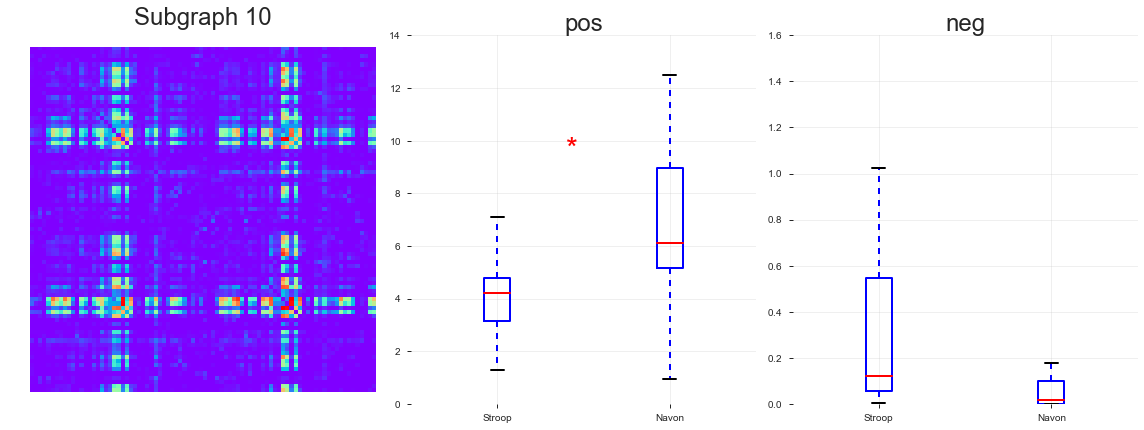

LH_lateraloccipital
LH_fusiform
RH_lateraloccipital
RH_fusiform
LH_precentral
LH_superiorparietal



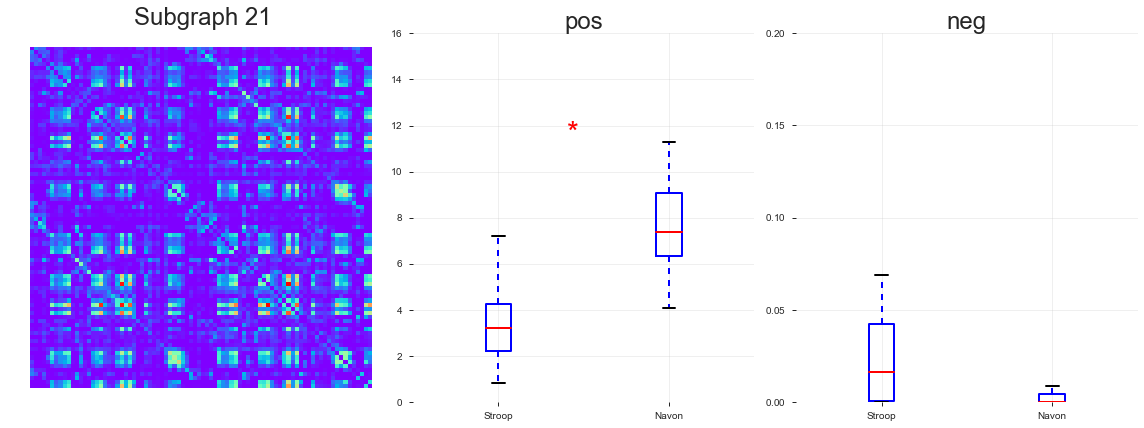

RH_rostralmiddlefrontal
RH_parsorbitalis
RH_caudalmiddlefrontal
RH_middletemporal
RH_inferiorparietal
RH_parsopercularis



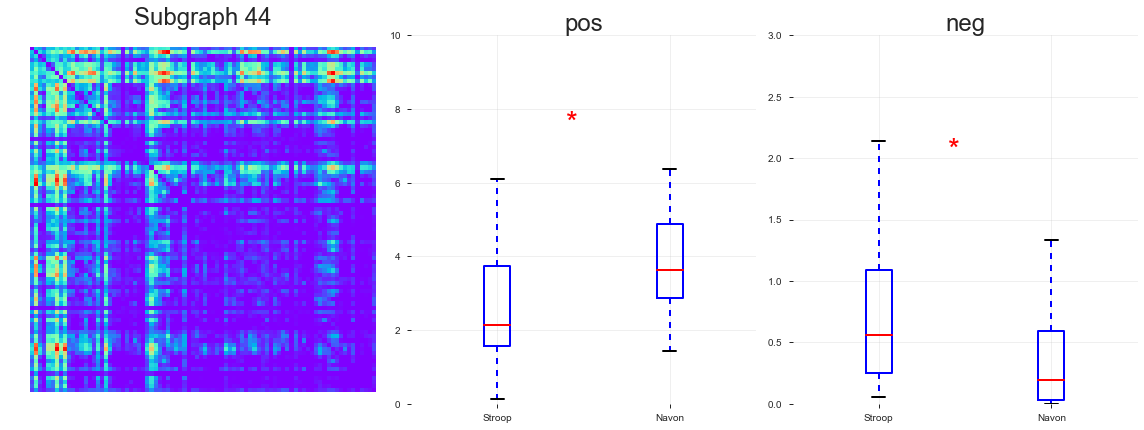

LH_cuneus
LH_pericalcarine
RH_pericalcarine
RH_cuneus
LH_lingual
RH_lingual



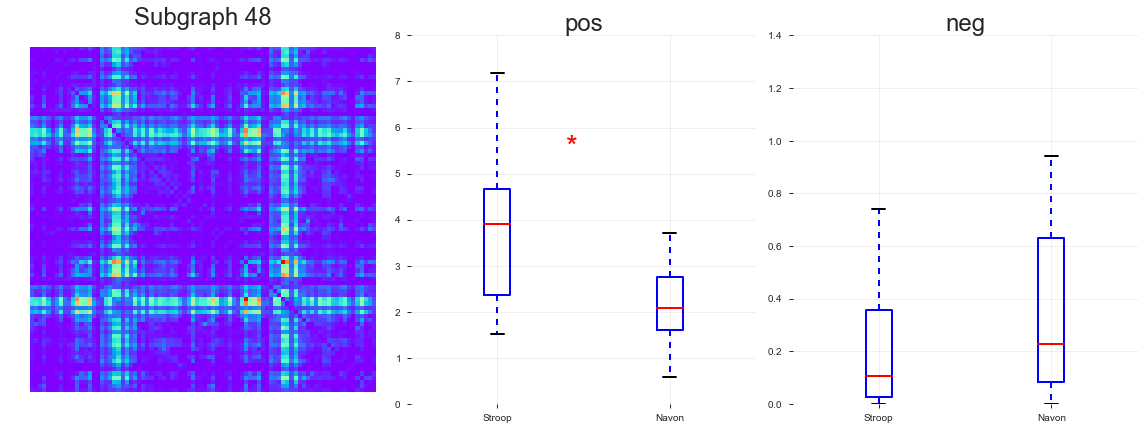

In [84]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_lbl = np.unique(cfg_key)
key_grp = [[['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
            ['adj_hi_pos_Navon', 'adj_lo_pos_Navon']],
           [['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop'],
            ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']]]


#sel_fac_ix = xrange(n_fac)
sel_fac_ix = real_ix[high_ix]
alpha = 0.05
n_comp = len(sel_fac_ix)*2
adj_alpha = alpha / n_comp

sel_fac_ix_between_sig = [9, 20, 43, 47]

# Plot each result
for fac_ii in sel_fac_ix_between_sig: #sel_fac_ix:
    plt.figure(figsize=(16,6))
    ax = plt.subplot(1, 1+len(key_grp), 1)
    ax.matshow(conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]), cmap='rainbow')
    ax.set_axis_off()

    ax.set_title('Subgraph {}'.format(fac_ii+1))
    sort_roi = np.argsort(np.sum(conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]), axis=0))[::-1]
    print('{}\n{}\n{}\n{}\n{}\n{}\n'.format(all_roi_names[sort_roi[0]],
                                            all_roi_names[sort_roi[1]],
                                            all_roi_names[sort_roi[2]],
                                            all_roi_names[sort_roi[3]],
                                            all_roi_names[sort_roi[4]],
                                            all_roi_names[sort_roi[5]]))

    for grp_ii, grp in enumerate(key_grp):
        dists = []

        for key in grp:
            key_hi_ix = np.flatnonzero(cfg_key == key[0])
            key_lo_ix = np.flatnonzero(cfg_key == key[1])
            
            subj_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)

            mean_subj_coef = np.mean((subj_hi+subj_lo)/2, axis=1)
            dists.append(mean_subj_coef)
            #all_coef = fac_coef[fac_ii, key_ix]
            #dists.append(all_coef)

        ax = plt.subplot(1, 1+len(key_grp), grp_ii+2)
        ax.boxplot(dists)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticklabels([gg[0].split('_')[-1] for gg in grp])

        ax.set_title('{}'.format(grp[0][0].split('_')[-2]))
        
        ts, pv = stats.ttest_rel(dists[0], dists[1])
        #rs_hi_ts, rs_hi_pv = stats.ttest_rel(dists[0], dists[2])
        #lo_hi_ts, lo_hi_pv = stats.ttest_rel(dists[1], dists[2])            
     
        
        if pv < adj_alpha:
            ax.text(1.4, np.max(dists)*0.75, '*', fontsize=30, color='r')

    plt.show()

## Subgraph Expression vs Behavior

### Load Behavioral Data

In [60]:
df_beh = io.loadmat('{}/BehavioralData_CogControlCorrect.mat'.format(path_CoreData))

stroop_lbl = [lbl[0] for lbl in df_beh['StroopLabels'][0]]
navon_lbl = [lbl[0] for lbl in df_beh['NavonLabels'][0]]
stroop_beh = df_beh['StroopCorrectOnly']
navon_beh = df_beh['NavonCorrectOnly']

bad_subj_ix = [1, 6]
good_subj_ix = np.setdiff1d(np.arange(stroop_beh.shape[0]), bad_subj_ix)

### Predicting No-Interference/Shifting Median RT

LH_cuneus
LH_pericalcarine
RH_cuneus
LH_lingual
RH_pericalcarine
RH_lingual

Stroop-pos: rho: -0.0178899136884, pval: 0.92800466626, sig:  
Stroop-neg: rho: -0.0682267144221, pval: 0.730121130354, sig:  
Navon-pos: rho: -0.203536907715, pval: 0.298880450725, sig:  
Navon-neg: rho: -0.259035867874, pval: 0.183173089016, sig:  


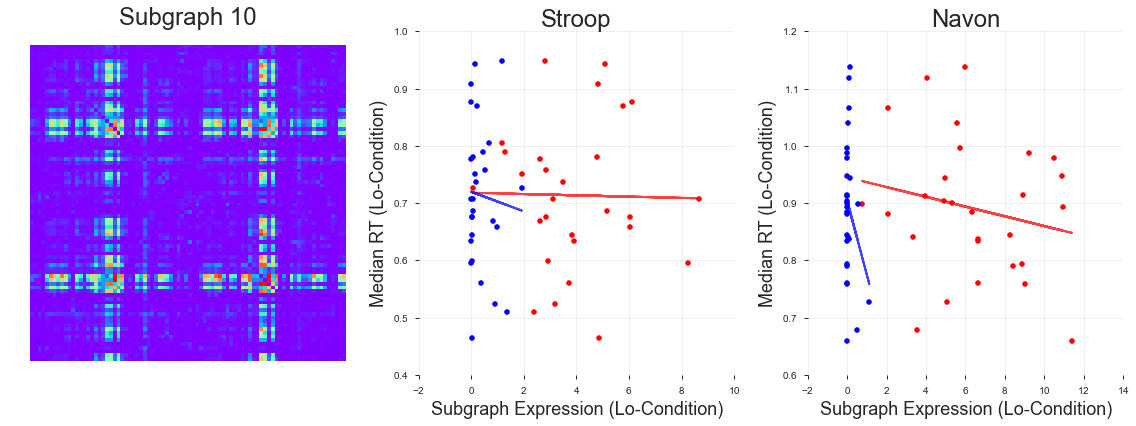

RH_caudalmiddlefrontal
RH_inferiorparietal
RH_rostralmiddlefrontal
RH_parsorbitalis
LH_lateraloccipital
RH_middletemporal

Stroop-pos: rho: -0.246431459456, pval: 0.206178035989, sig:  
Stroop-neg: rho: -0.192216253018, pval: 0.327126430932, sig:  
Navon-pos: rho: -0.342999090751, pval: 0.0739558381508, sig:  
Navon-neg: rho: 0.202935230118, pval: 0.300341893388, sig:  


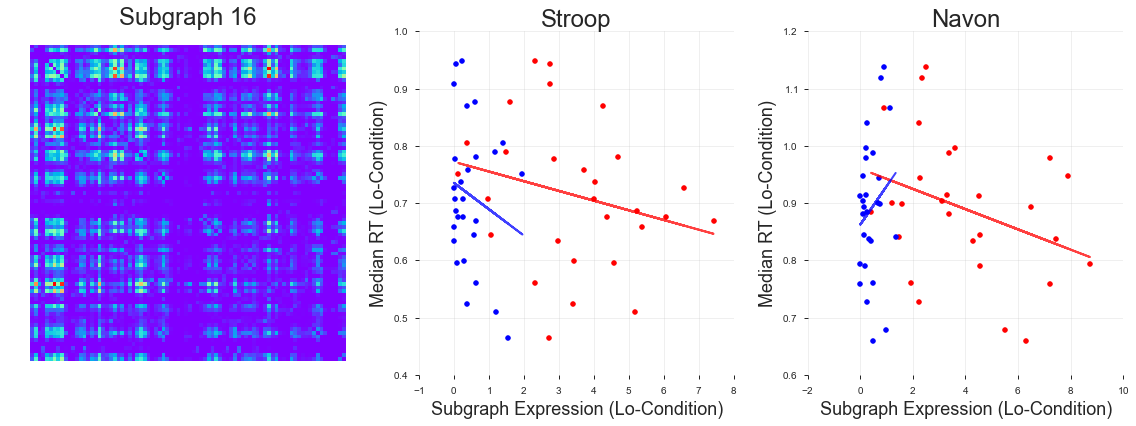

RH_postcentral
LH_medialorbitofrontal
LH_paracentral
LH_rostralanteriorcingulate
LH_postcentral
RH_paracentral

Stroop-pos: rho: -0.339829101669, pval: 0.0768426772686, sig:  
Stroop-neg: rho: 0.113539676102, pval: 0.565109115337, sig:  
Navon-pos: rho: 0.223103344922, pval: 0.253793239568, sig:  
Navon-neg: rho: -0.0971344993346, pval: 0.622917905002, sig:  


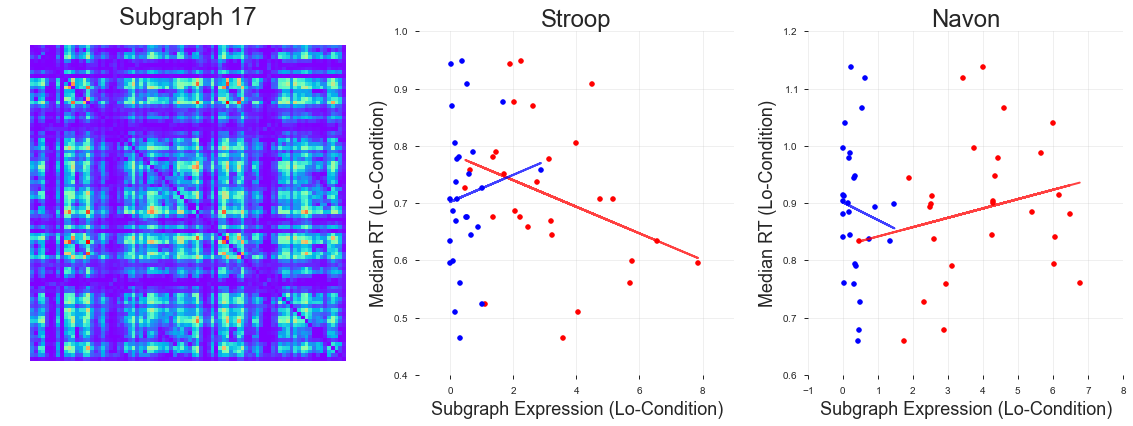

LH_lateraloccipital
LH_fusiform
RH_lateraloccipital
RH_fusiform
LH_precentral
LH_superiorparietal

Stroop-pos: rho: 0.00270707712908, pval: 0.989092135006, sig:  
Stroop-neg: rho: 0.0503228607701, pval: 0.799260680772, sig:  
Navon-pos: rho: -0.189064992319, pval: 0.335269734236, sig:  
Navon-neg: rho: 0.147311718296, pval: 0.454425893024, sig:  


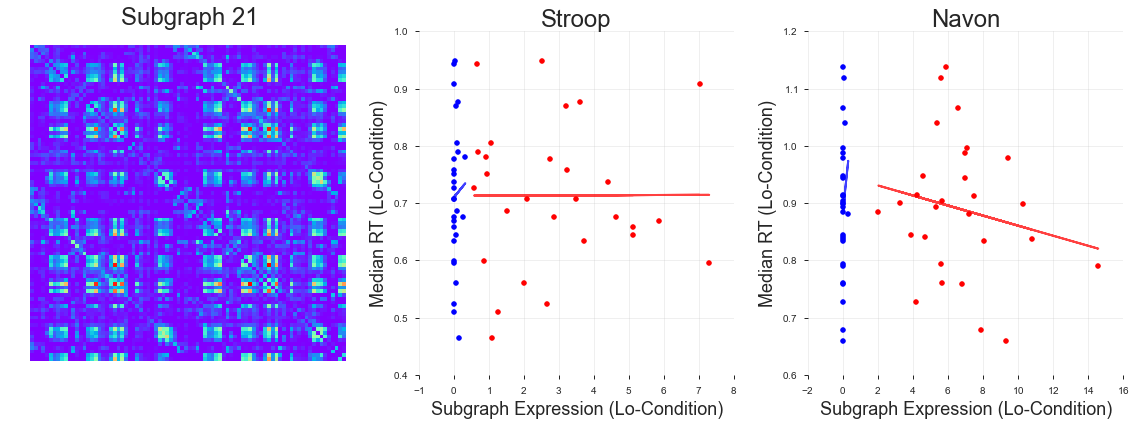

RH_rostralmiddlefrontal
RH_parsorbitalis
RH_caudalmiddlefrontal
RH_middletemporal
RH_inferiorparietal
RH_parsopercularis

Stroop-pos: rho: -0.212994774455, pval: 0.276495945076, sig:  
Stroop-neg: rho: -0.156527254662, pval: 0.426367366855, sig:  
Navon-pos: rho: -0.041397407106, pval: 0.834325927833, sig:  
Navon-neg: rho: -0.258572849627, pval: 0.183985064946, sig:  


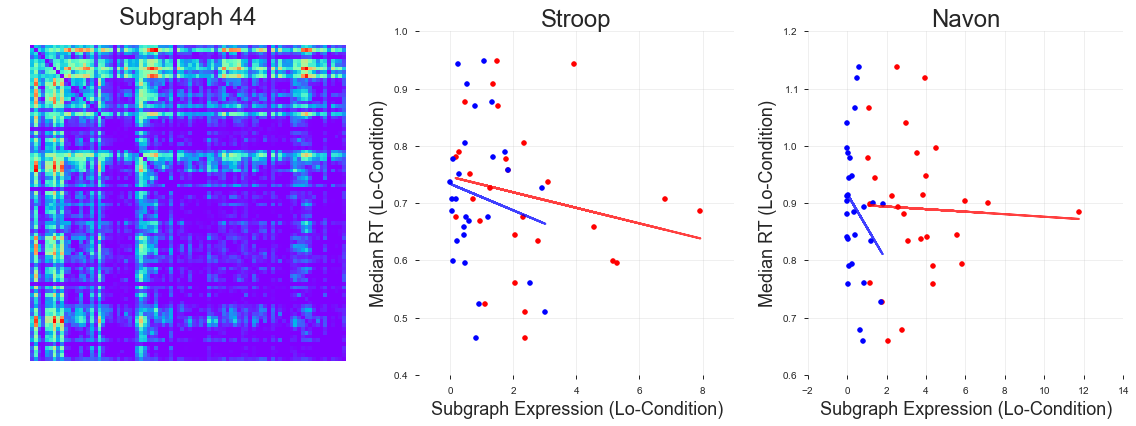

LH_cuneus
LH_pericalcarine
RH_pericalcarine
RH_cuneus
LH_lingual
RH_lingual

Stroop-pos: rho: -0.133345048657, pval: 0.498750690139, sig:  
Stroop-neg: rho: 0.0927680015688, pval: 0.638700539266, sig:  
Navon-pos: rho: 0.143799918729, pval: 0.46536994473, sig:  
Navon-neg: rho: -0.0654133389471, pval: 0.740864865091, sig:  


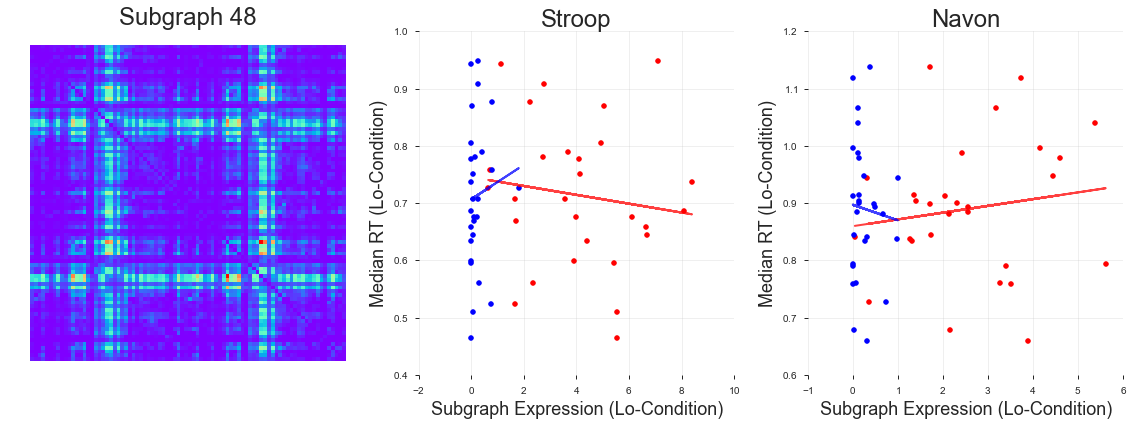

In [112]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_lbl = np.unique(cfg_key)
key_grp = [['adj_lo_pos_Stroop', 'adj_lo_neg_Stroop'],
           ['adj_lo_pos_Navon', 'adj_lo_neg_Navon']]
beh_grp = [stroop_beh[good_subj_ix, 8],
           navon_beh[good_subj_ix, 8]]
clrs = ['r', 'b']


sel_fac_ix = np.unique([sel_fac_ix_within_sig, sel_fac_ix_between_sig])
alpha = 0.05
n_comp = len(sel_fac_ix)
adj_alpha = alpha / n_comp

# Plot each result
for fac_ii in sel_fac_ix:
    plt.figure(figsize=(16,6))
    ax = plt.subplot(1, 1+len(key_grp), 1)
    ax.matshow(conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]), cmap='rainbow')
    ax.set_axis_off()

    ax.set_title('Subgraph {}'.format(fac_ii+1))
    sort_roi = np.argsort(np.sum(conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]), axis=0))[::-1]
    print('{}\n{}\n{}\n{}\n{}\n{}\n'.format(all_roi_names[sort_roi[0]],
                                            all_roi_names[sort_roi[1]],
                                            all_roi_names[sort_roi[2]],
                                            all_roi_names[sort_roi[3]],
                                            all_roi_names[sort_roi[4]],
                                            all_roi_names[sort_roi[5]]))

    for grp_ii, grp in enumerate(key_grp):
        rho_list = []

        ax = plt.subplot(1, 1+len(key_grp), grp_ii+2)
        
        for key_ii, key in enumerate(grp):
            key_ix = np.flatnonzero(cfg_key == key)
            mean_subj_coef = np.mean(fac_coef[fac_ii, key_ix].reshape(-1, 6), axis=1)
            
            m, b, rho, pval, stderr = stats.linregress(mean_subj_coef, beh_grp[grp_ii])
            ax.plot(mean_subj_coef, m*mean_subj_coef+b, color=clrs[key_ii], alpha=0.75)
            ax.scatter(mean_subj_coef, beh_grp[grp_ii], color=clrs[key_ii])
            
            if pval < adj_alpha:
                sig = '*'
            else:
                sig = ' '
            print('{}-{}: rho: {}, pval: {}, sig: {}'.format(key.split('_')[-1],
                                                  key.split('_')[-2],
                                                  rho, pval, sig))
            
        ax.set_title('{}'.format(grp[0].split('_')[-1]))
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('Subgraph Expression (Lo-Condition)')
        ax.set_ylabel('Median RT (Lo-Condition)')        
    plt.show()

### Predicting Interference/Shifting Median RT (from Hi alone)

LH_cuneus
LH_pericalcarine
RH_cuneus
LH_lingual
RH_pericalcarine
RH_lingual

Stroop-pos: rho: -0.170451139547, pval: 0.385836588437, sig:  
Stroop-neg: rho: 0.0310867314021, pval: 0.87521848847, sig:  
Navon-pos: rho: 0.0102604741853, pval: 0.958672757711, sig:  
Navon-neg: rho: -0.00338438246583, pval: 0.986363233831, sig:  


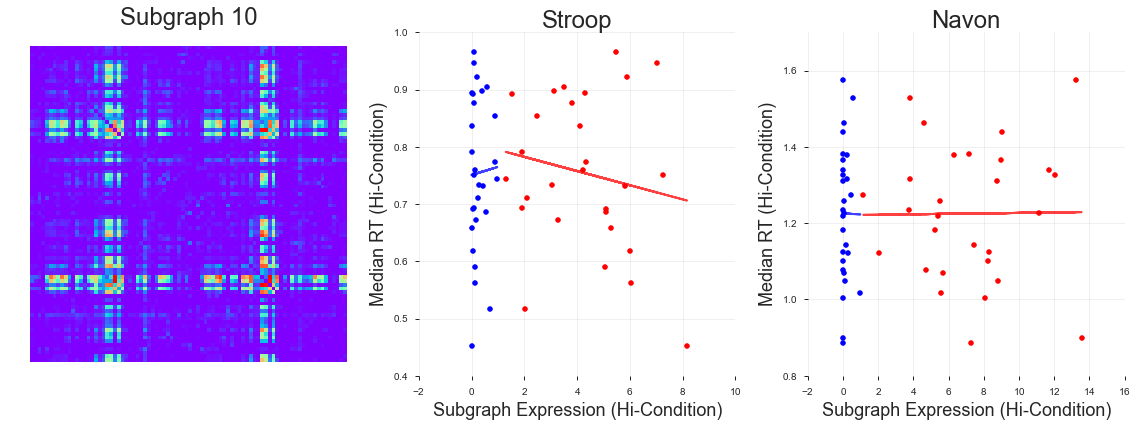

RH_caudalmiddlefrontal
RH_inferiorparietal
RH_rostralmiddlefrontal
RH_parsorbitalis
LH_lateraloccipital
RH_middletemporal

Stroop-pos: rho: -0.492051991688, pval: 0.00782208675605, sig: *
Stroop-neg: rho: 0.367330570487, pval: 0.0544865648443, sig:  
Navon-pos: rho: 0.0742762063324, pval: 0.707189685252, sig:  
Navon-neg: rho: -0.0695098955383, pval: 0.725237274009, sig:  


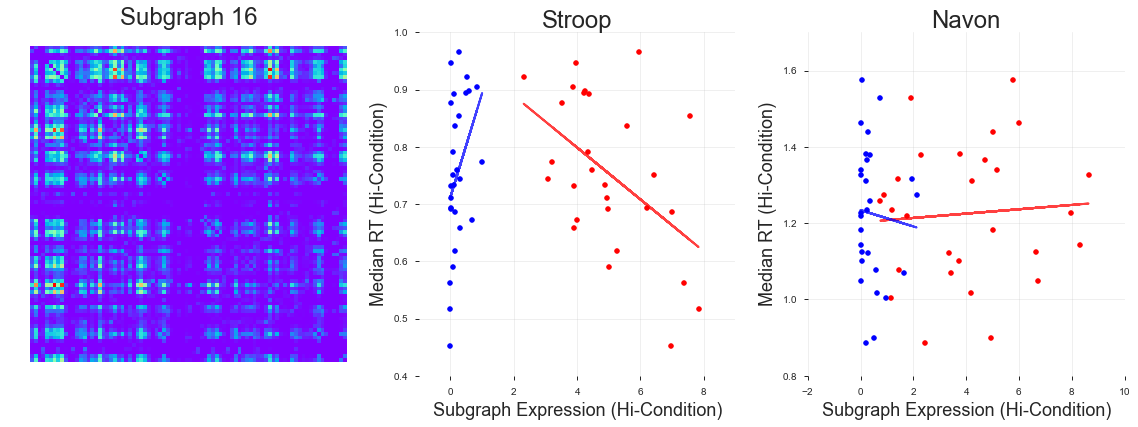

RH_postcentral
LH_medialorbitofrontal
LH_paracentral
LH_rostralanteriorcingulate
LH_postcentral
RH_paracentral

Stroop-pos: rho: -0.249930912764, pval: 0.199602299, sig:  
Stroop-neg: rho: 0.0713680185651, pval: 0.718183803942, sig:  
Navon-pos: rho: 0.117320111257, pval: 0.552140796442, sig:  
Navon-neg: rho: -0.0539730243232, pval: 0.785025364068, sig:  


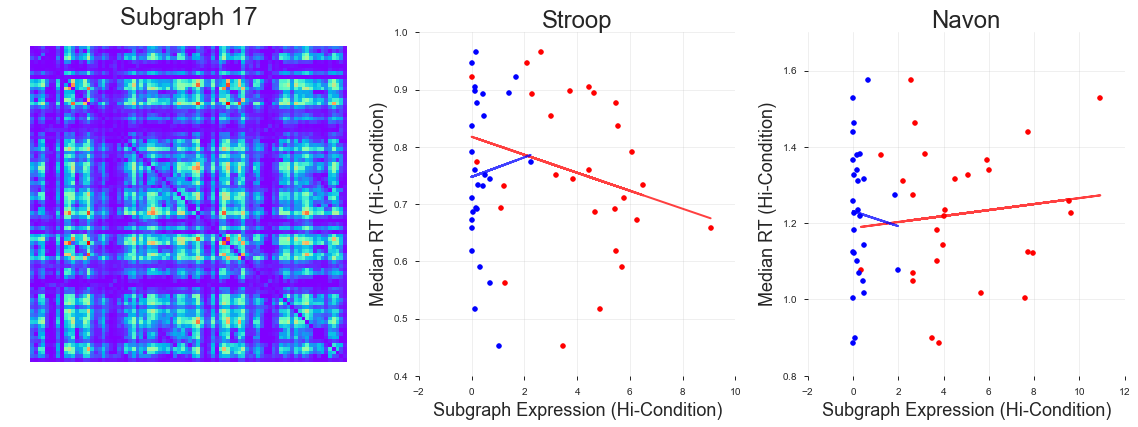

LH_lateraloccipital
LH_fusiform
RH_lateraloccipital
RH_fusiform
LH_precentral
LH_superiorparietal

Stroop-pos: rho: -0.189402153887, pval: 0.334392642691, sig:  
Stroop-neg: rho: 0.177865206091, pval: 0.365193131576, sig:  
Navon-pos: rho: -0.00262935542691, pval: 0.989405288349, sig:  
Navon-neg: rho: -0.0339388607293, pval: 0.863870844983, sig:  


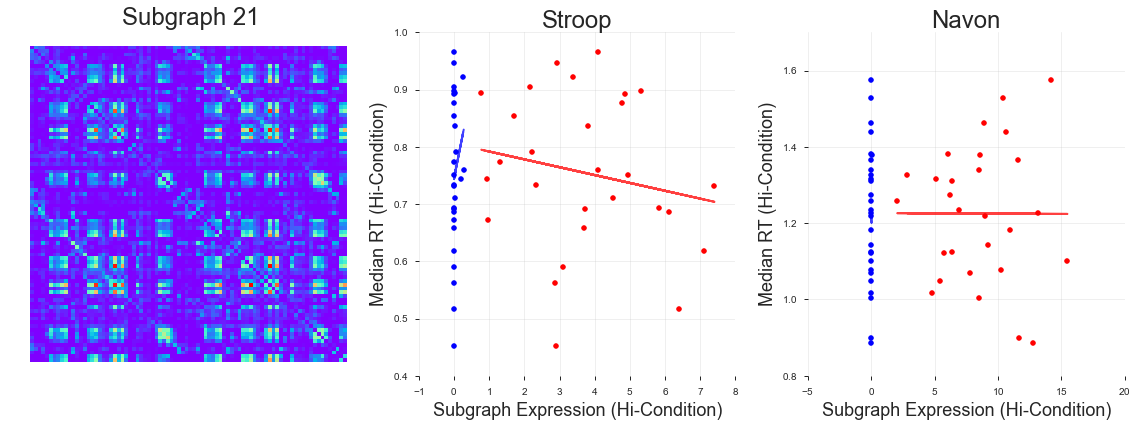

RH_rostralmiddlefrontal
RH_parsorbitalis
RH_caudalmiddlefrontal
RH_middletemporal
RH_inferiorparietal
RH_parsopercularis

Stroop-pos: rho: -0.059414960895, pval: 0.763928621342, sig:  
Stroop-neg: rho: 0.0753414985224, pval: 0.703176653418, sig:  
Navon-pos: rho: -0.0445921172182, pval: 0.821735619743, sig:  
Navon-neg: rho: 0.185578905591, pval: 0.344419990743, sig:  


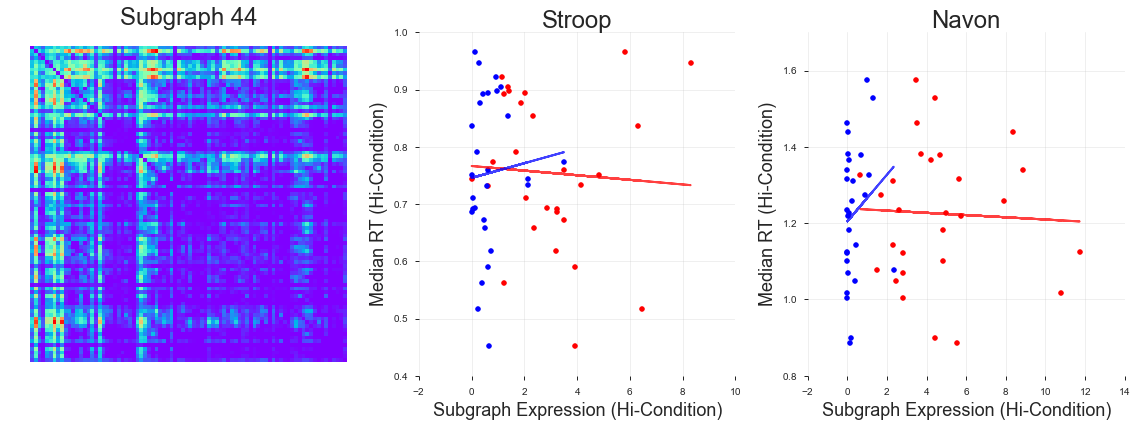

LH_cuneus
LH_pericalcarine
RH_pericalcarine
RH_cuneus
LH_lingual
RH_lingual

Stroop-pos: rho: -0.067023343279, pval: 0.734710606528, sig:  
Stroop-neg: rho: 0.255026479485, pval: 0.190287415979, sig:  
Navon-pos: rho: -0.0784893898709, pval: 0.691364069479, sig:  
Navon-neg: rho: 0.0996267388818, pval: 0.613981708773, sig:  


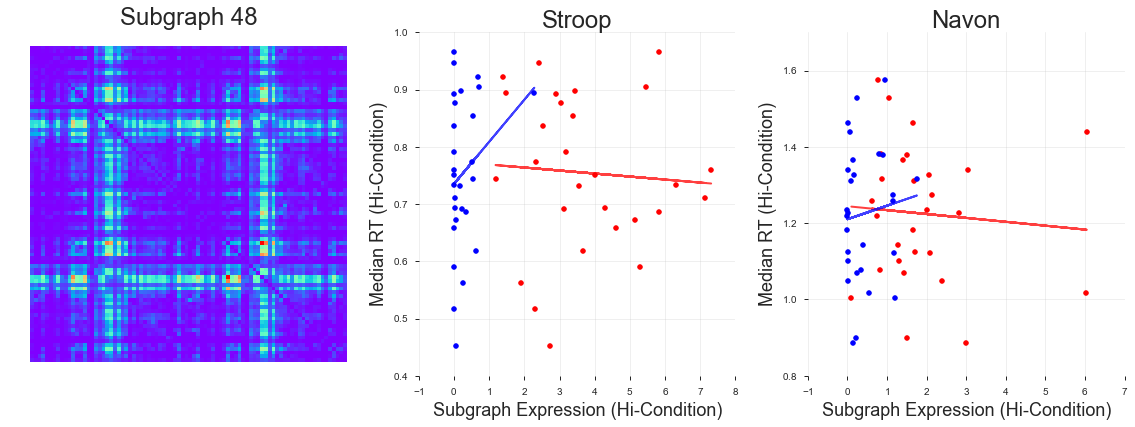

In [113]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_lbl = np.unique(cfg_key)
key_grp = [['adj_hi_pos_Stroop', 'adj_hi_neg_Stroop'],
           ['adj_hi_pos_Navon', 'adj_hi_neg_Navon']]
beh_grp = [stroop_beh[good_subj_ix, 6],
           navon_beh[good_subj_ix, 6]]
clrs = ['r', 'b']


sel_fac_ix = np.unique([sel_fac_ix_within_sig, sel_fac_ix_between_sig])
alpha = 0.05
n_comp = len(sel_fac_ix)
adj_alpha = alpha / n_comp

# Plot each result
for fac_ii in sel_fac_ix:
    plt.figure(figsize=(16,6))
    ax = plt.subplot(1, 1+len(key_grp), 1)
    ax.matshow(conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]), cmap='rainbow')
    ax.set_axis_off()

    ax.set_title('Subgraph {}'.format(fac_ii+1))
    sort_roi = np.argsort(np.sum(conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]), axis=0))[::-1]
    print('{}\n{}\n{}\n{}\n{}\n{}\n'.format(all_roi_names[sort_roi[0]],
                                            all_roi_names[sort_roi[1]],
                                            all_roi_names[sort_roi[2]],
                                            all_roi_names[sort_roi[3]],
                                            all_roi_names[sort_roi[4]],
                                            all_roi_names[sort_roi[5]]))

    for grp_ii, grp in enumerate(key_grp):
        rho_list = []

        ax = plt.subplot(1, 1+len(key_grp), grp_ii+2)
        
        for key_ii, key in enumerate(grp):
            key_ix = np.flatnonzero(cfg_key == key)
            mean_subj_coef = np.mean(fac_coef[fac_ii, key_ix].reshape(-1, 6), axis=1)
            
            m, b, rho, pval, stderr = stats.linregress(mean_subj_coef, beh_grp[grp_ii])
            ax.plot(mean_subj_coef, m*mean_subj_coef+b, color=clrs[key_ii], alpha=0.75)
            ax.scatter(mean_subj_coef, beh_grp[grp_ii], color=clrs[key_ii])
            
            if pval < adj_alpha:
                sig = '*'
            else:
                sig = ' '
            print('{}-{}: rho: {}, pval: {}, sig: {}'.format(key.split('_')[-1],
                                                             key.split('_')[-2],
                                                             rho, pval, sig))
            
        ax.set_title('{}'.format(grp[0].split('_')[-1]))
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('Subgraph Expression (Hi-Condition)')
        ax.set_ylabel('Median RT (Hi-Condition)')        
    plt.show()

### Predicting Interference/Shifting Median RT (from Hi-Lo Contrast)

LH_cuneus
LH_pericalcarine
RH_cuneus
LH_lingual
RH_pericalcarine
RH_lingual

Stroop-pos: rho: -0.0887437503089, pval: 0.65338398288, sig:  
Stroop-neg: rho: 0.0975629728104, pval: 0.62137779521, sig:  
Navon-pos: rho: 0.237576110442, pval: 0.223474221922, sig:  
Navon-neg: rho: 0.333912491194, pval: 0.0824610049297, sig:  


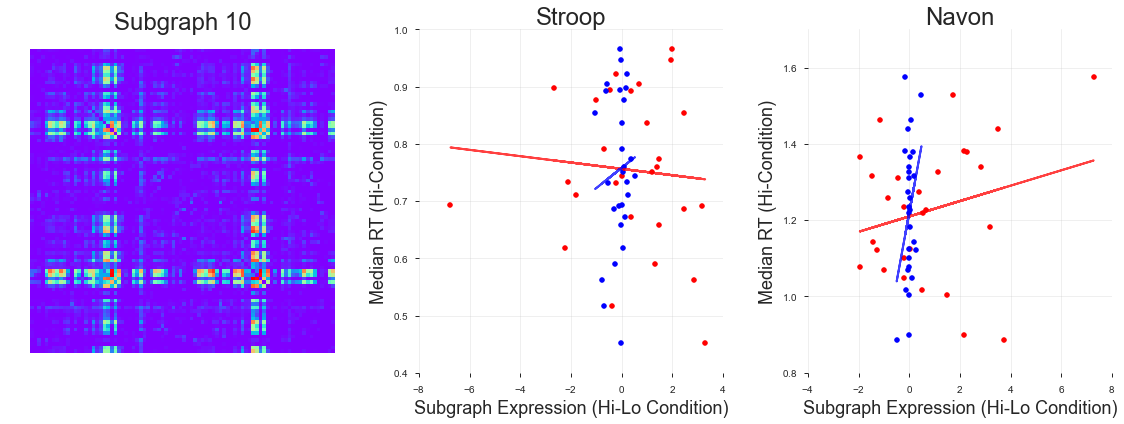

RH_caudalmiddlefrontal
RH_inferiorparietal
RH_rostralmiddlefrontal
RH_parsorbitalis
LH_lateraloccipital
RH_middletemporal

Stroop-pos: rho: -0.311138560171, pval: 0.107044529876, sig:  
Stroop-neg: rho: 0.453723510676, pval: 0.0153039449096, sig:  
Navon-pos: rho: 0.498349824495, pval: 0.00695432467936, sig: *
Navon-neg: rho: -0.163773544863, pval: 0.404990330648, sig:  


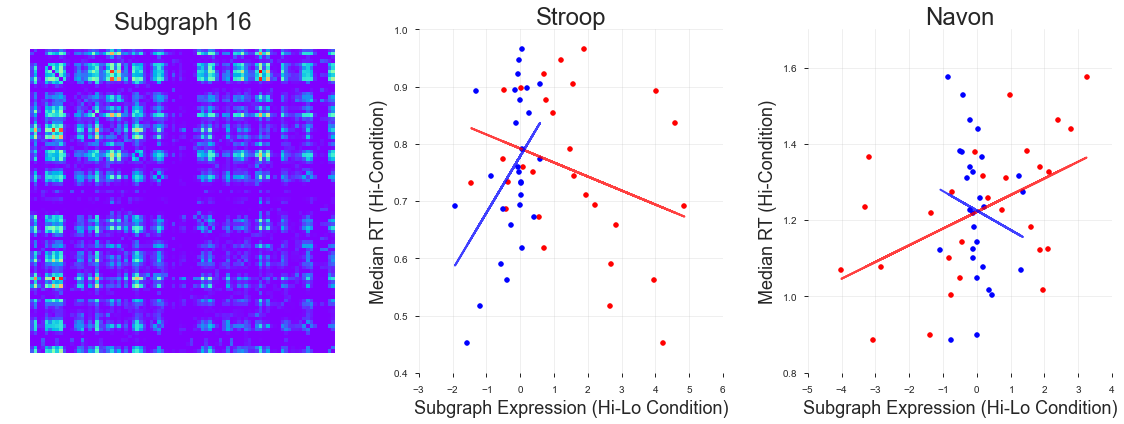

RH_postcentral
LH_medialorbitofrontal
LH_paracentral
LH_rostralanteriorcingulate
LH_postcentral
RH_paracentral

Stroop-pos: rho: 0.0318678741194, pval: 0.872108092156, sig:  
Stroop-neg: rho: 0.00354870457646, pval: 0.985701192321, sig:  
Navon-pos: rho: -0.0231706225477, pval: 0.906833977214, sig:  
Navon-neg: rho: 0.0490117802231, pval: 0.804389396212, sig:  


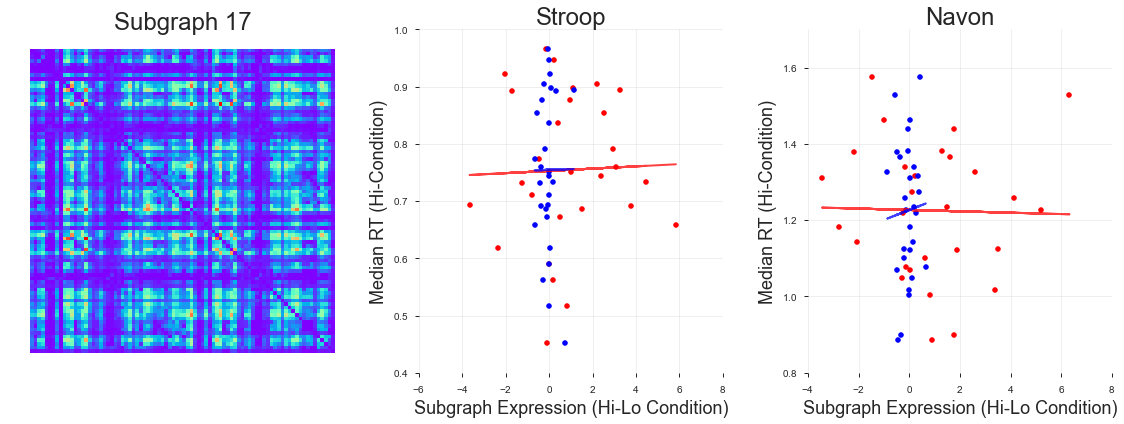

LH_lateraloccipital
LH_fusiform
RH_lateraloccipital
RH_fusiform
LH_precentral
LH_superiorparietal

Stroop-pos: rho: -0.237971048392, pval: 0.222682663041, sig:  
Stroop-neg: rho: 0.0491839623208, pval: 0.803715393348, sig:  
Navon-pos: rho: 0.236330692876, pval: 0.225982755164, sig:  
Navon-neg: rho: -0.0693010266387, pval: 0.726031529787, sig:  


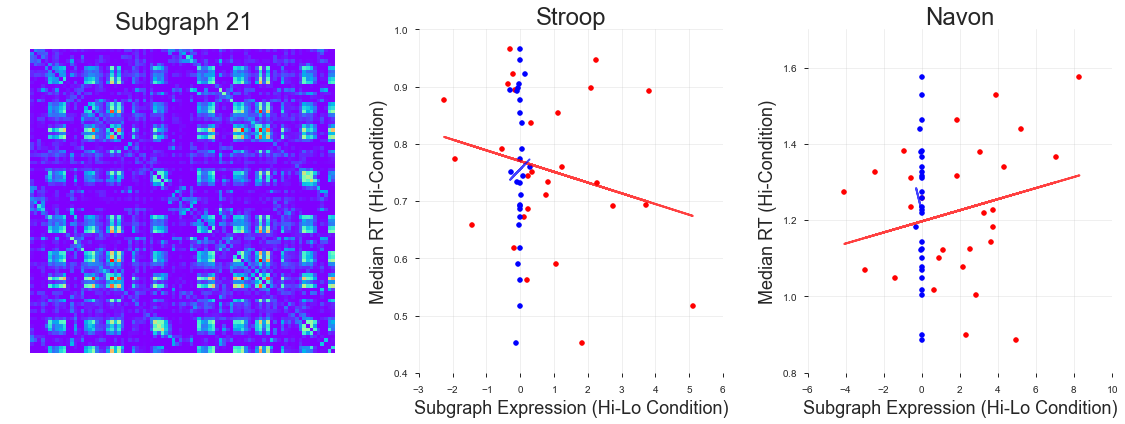

RH_rostralmiddlefrontal
RH_parsorbitalis
RH_caudalmiddlefrontal
RH_middletemporal
RH_inferiorparietal
RH_parsopercularis

Stroop-pos: rho: 0.106468479131, pval: 0.589728649124, sig:  
Stroop-neg: rho: 0.234437906613, pval: 0.229831307325, sig:  
Navon-pos: rho: -0.0531101546869, pval: 0.78838456026, sig:  
Navon-neg: rho: 0.355788290355, pval: 0.0631478435762, sig:  


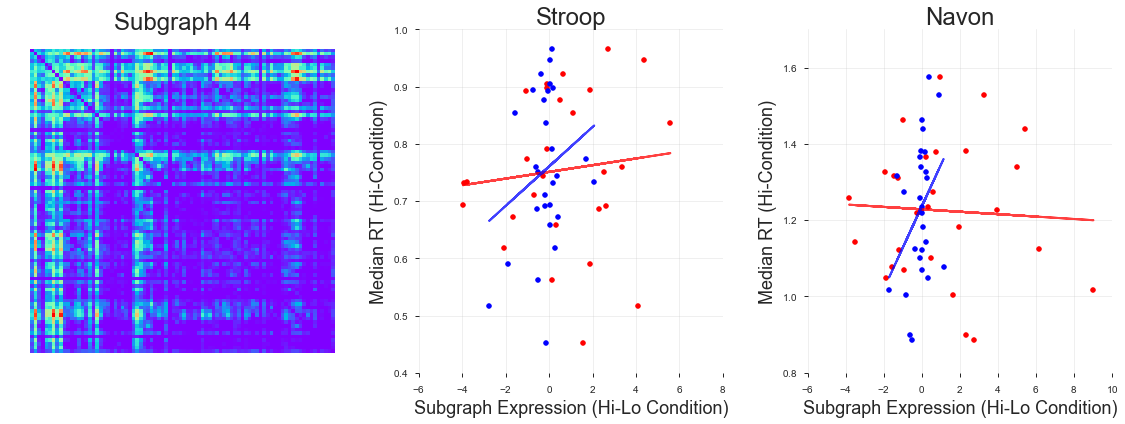

LH_cuneus
LH_pericalcarine
RH_pericalcarine
RH_cuneus
LH_lingual
RH_lingual

Stroop-pos: rho: 0.0277791796135, pval: 0.888408255984, sig:  
Stroop-neg: rho: 0.125684949572, pval: 0.523945413167, sig:  
Navon-pos: rho: -0.159356008582, pval: 0.417949697907, sig:  
Navon-neg: rho: 0.10685875108, pval: 0.588357808413, sig:  


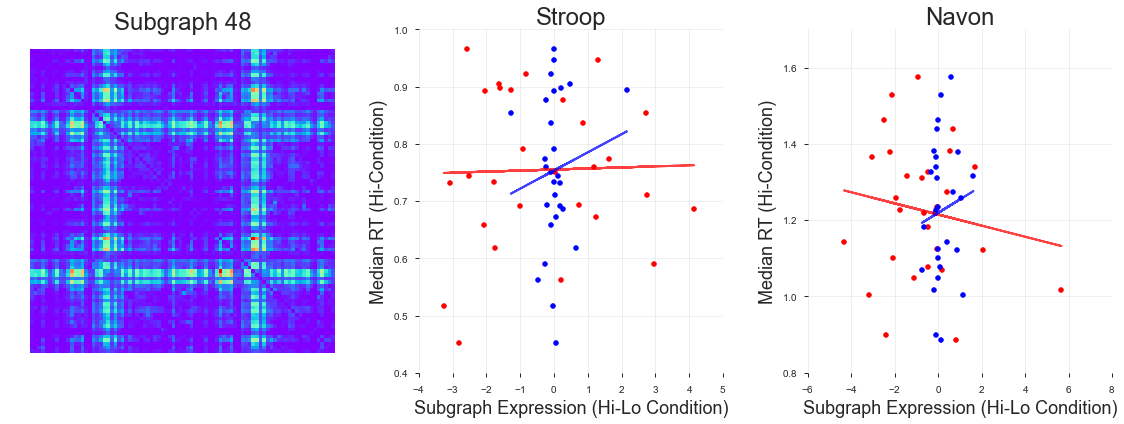

In [119]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_lbl = np.unique(cfg_key)
key_grp = [[['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
            ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop']],
           [['adj_hi_pos_Navon', 'adj_lo_pos_Navon'],
            ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']]]
beh_grp = [stroop_beh[good_subj_ix, 6],
           navon_beh[good_subj_ix, 6]]
clrs = ['r', 'b']


sel_fac_ix = np.unique([sel_fac_ix_within_sig, sel_fac_ix_between_sig])
alpha = 0.05
n_comp = len(sel_fac_ix)
adj_alpha = alpha / n_comp

# Plot each result
for fac_ii in sel_fac_ix:
    plt.figure(figsize=(16,6))
    ax = plt.subplot(1, 1+len(key_grp), 1)
    ax.matshow(conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]), cmap='rainbow')
    ax.set_axis_off()

    ax.set_title('Subgraph {}'.format(fac_ii+1))
    sort_roi = np.argsort(np.sum(conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]), axis=0))[::-1]
    print('{}\n{}\n{}\n{}\n{}\n{}\n'.format(all_roi_names[sort_roi[0]],
                                            all_roi_names[sort_roi[1]],
                                            all_roi_names[sort_roi[2]],
                                            all_roi_names[sort_roi[3]],
                                            all_roi_names[sort_roi[4]],
                                            all_roi_names[sort_roi[5]]))

    for grp_ii, grp in enumerate(key_grp):
        rho_list = []

        ax = plt.subplot(1, 1+len(key_grp), grp_ii+2)
        
        for key_ii, key in enumerate(grp):
            key_hi_ix = np.flatnonzero(cfg_key == key[0])
            key_lo_ix = np.flatnonzero(cfg_key == key[1])
            
            hi_fac_coef = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            lo_fac_coef = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)
            mean_subj_coef = np.mean(hi_fac_coef-lo_fac_coef, axis=1)
            
            m, b, rho, pval, stderr = stats.linregress(mean_subj_coef, beh_grp[grp_ii])
            ax.plot(mean_subj_coef, m*mean_subj_coef+b, color=clrs[key_ii], alpha=0.75)
            ax.scatter(mean_subj_coef, beh_grp[grp_ii], color=clrs[key_ii])
            
            if pval < adj_alpha:
                sig = '*'
            else:
                sig = ' '
            print('{}-{}: rho: {}, pval: {}, sig: {}'.format(key[0].split('_')[-1],
                                                             key[0].split('_')[-2],
                                                             rho, pval, sig))
            
        ax.set_title('{}'.format(grp[0][0].split('_')[-1]))
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('Subgraph Expression (Hi-Lo Condition)')
        ax.set_ylabel('Median RT (Hi-Condition)')        
    plt.show()